## FCI

In [1]:
import numpy as np
import openfermion
from openfermion.chem import MolecularData
from openfermionqchem import run_qchem

In [2]:
def Fermi_ops(ops,body="ONE"):
    f_ops = openfermion.FermionOperator()
    if body == "ONE":
        for p in range(len(ops)):
            for q in range(len(ops)):
                if abs(ops[p,q]) > 1.0e-8:
                    f_ops += openfermion.FermionOperator(((p,1),(q,0)), ops[p,q])
    elif body == "TWO":
        for p in range(len(ops)):
            for q in range(len(ops[p])):
                for r in range(len(ops[p][q])):
                    for s in range(len(ops[p][q][r])):
                        f_ops += openfermion.FermionOperator(((p,1),(q,1),(r,0),(s,0)), ops[p,q,r,s])
    else:
        print("Something wrong")
    return f_ops

def rm_duplicate(energy):
    temp1,temp2 = [],[]
    for i in range(len(energy)):
        if np.round(energy[i],5) in temp2:
            continue
        temp1.append(energy[i])
        temp2.append(np.round(energy[i],5))
    return temp1[:10]

def str_format(bond,energy):
    string1,string2 = "Total Energy\n","Excitation Energy\n"
    
    for i in range(len(bond)):
        string1 += "{:4.2f}".format(bond[i])
        string2 += "{:4.2f}".format(bond[i])
#         for j in range(len(energy[i])):
        for j in range(9):
            string1 += "{:15.10f}".format(energy[i][j])
        string1 += '\n'

        for j in range(1,9):
            string2 += "{:15.10f}".format((energy[i][j] - energy[i][0]) * 27.211324570273)
        string2 += '\n'
        
    print(string1+string2)

## H2/6-31G

In [3]:
# Set molecule parameters.
# We do not run calculations through OpenFermion directly.
basis        = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
bond_length_interval = 0.1
n_points = 19
bond_lengths = []
fci_energies = []

for point in range(n_points):
# for point in range(1):
    bond_length    = 0.2 + point * bond_length_interval
    geometry       = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    # Generate a MolecularData instance
    molecule       = MolecularData(geometry, basis, multiplicity)
    
    file_directory = '/Users/yongbinkim/Desktop/venv/qeom/OpenFermion-QChem/examples/H2/eom-ccsd/6-31g/'\
                      +str(round(bond_length,2))+'/'
    # Update the MolecularData instance
    molecule   = run_qchem(molecule,file_directory=file_directory,output_name='test_qis')
    fermi      = Fermi_ops(molecule.one_body_integrals)
    fermi     += Fermi_ops(molecule.two_body_integrals*0.25, body="TWO")
    sparse_ham = openfermion.linalg.get_number_preserving_sparse_operator(fermi,molecule.n_qubits,molecule.n_electrons)

    mat  = sparse_ham.toarray() # type: np.ndarray
    w,v  = np.linalg.eigh(mat)
    ene  = rm_duplicate(w+molecule.nuclear_repulsion)
    fci_energies.append(ene)
    bond_lengths.append(bond_length)
    
fci_energies = np.array(fci_energies)
bond_lengths = np.array(bond_lengths)


In [4]:
str_format(bond_lengths,fci_energies)

Total Energy
0.20   0.0651688810   0.8030234409   0.8551218472   0.9101296015   1.0891847993   2.0434667158   2.0526330417   2.1886038961   2.2442191890
0.30  -0.6605101759   0.0119056324   0.0774023429   0.1652016727   0.3600191380   1.1490607985   1.1995968454   1.3217789415   1.4258706292
0.40  -0.9506786523  -0.3444728748  -0.2612218792  -0.1357272741   0.0691421836   0.6844123667   0.7908583563   0.8918502351   1.0643404407
0.50  -1.0778638981  -0.5364843027  -0.4313412608  -0.2628944466  -0.0550981841   0.3885683018   0.5621976966   0.6311731188   0.7138347180
0.60  -1.1319534575  -0.6534749528  -0.5231360425  -0.3054086983  -0.1017376457   0.1767450058   0.4261057993   0.4495517271   0.4502029388
0.70  -1.1501568433  -0.7321053573  -0.5749666170  -0.3015536406  -0.1083760363   0.0144206074   0.2738968143   0.3119865215   0.3470239511
0.80  -1.1500278825  -0.7890798215  -0.6056250122  -0.2711633197  -0.1147564620  -0.0937890272   0.1576055034   0.2072390304   0.3023536550
0.90  -

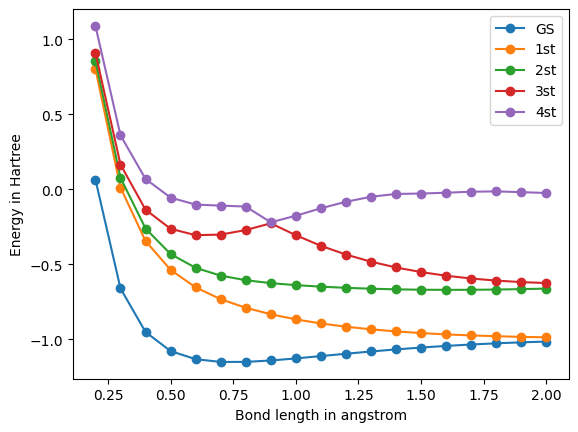

In [5]:
# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies[:,0], 'o-', label='GS')
plt.plot(bond_lengths, fci_energies[:,1], 'o-', label='1st')
plt.plot(bond_lengths, fci_energies[:,2], 'o-', label='2st')
plt.plot(bond_lengths, fci_energies[:,3], 'o-', label='3st')
plt.plot(bond_lengths, fci_energies[:,4], 'o-', label='4st')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend()
plt.show()

## H4/STO-3G

In [6]:
# Set molecule parameters.
# We do not run calculations through OpenFermion directly.
basis        = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
bond_length_interval = 0.05
n_points = 14
bond_lengths = []
fci_energies = []

for point in range(n_points):
    bond_length    = 1.75 + point * bond_length_interval
    geometry       = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    # Generate a MolecularData instance
    molecule       = MolecularData(geometry, basis, multiplicity)
    
    file_directory = '/Users/yongbinkim/Desktop/venv/qeom/OpenFermion-QChem/examples/H4/eom-ccsd/sto-3g/'\
                      +str(round(bond_length,3)).ljust(4,"0")+'/'
    # Update the MolecularData instance
    molecule   = run_qchem(molecule,file_directory=file_directory,output_name='test_qis')
    fermi      = Fermi_ops(molecule.one_body_integrals)
    fermi     += Fermi_ops(molecule.two_body_integrals*0.25, body="TWO")
    sparse_ham = openfermion.linalg.get_number_preserving_sparse_operator(fermi,molecule.n_qubits,molecule.n_electrons)

    mat  = sparse_ham.toarray() # type: np.ndarray
    w,v  = np.linalg.eigh(mat)
    ene  = rm_duplicate(w+molecule.nuclear_repulsion)
    fci_energies.append(ene)
    bond_lengths.append(bond_length)
    
fci_energies = np.array(fci_energies)
bond_lengths = np.array(bond_lengths)

In [7]:
str_format(bond_lengths,fci_energies)

Total Energy
1.75  -1.9652631234  -1.9086347521  -1.8497955715  -1.8186022421  -1.7939645234  -1.7458051993  -1.5934387583  -1.4552800866  -1.4508298728
1.80  -1.9689148383  -1.9061520502  -1.8555538048  -1.8135832346  -1.7922912084  -1.7511590831  -1.5842032584  -1.4566737218  -1.4527066808
1.85  -1.9723388034  -1.9038811844  -1.8604988782  -1.8090105093  -1.7907768958  -1.7557329173  -1.5750926038  -1.4573181268  -1.4537898485
1.90  -1.9754663014  -1.9018317115  -1.8647401391  -1.8049395884  -1.7894246325  -1.7596355158  -1.5661578305  -1.4573271110  -1.4541962422
1.95  -1.9782747565  -1.9000032610  -1.8683729474  -1.8013719682  -1.7882304691  -1.7629612326  -1.5574397657  -1.4567997819  -1.4540280392
2.00  -1.9807672978  -1.8983882337  -1.8714804696  -1.7982800845  -1.7871858154  -1.7657918713  -1.5489705536  -1.4558224108  -1.4533745205
2.05  -1.9829606459  -1.8969739229  -1.8741350294  -1.7956220937  -1.7862791010  -1.7681981271  -1.5407748187  -1.4544698488  -1.4523134312
2.10  -

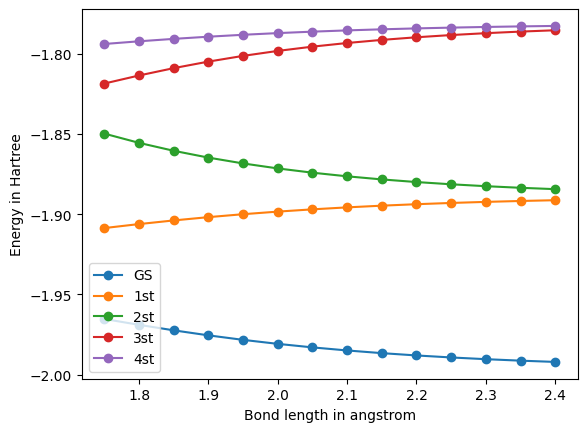

In [8]:
# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies[:,0], 'o-', label='GS')
plt.plot(bond_lengths, fci_energies[:,1], 'o-', label='1st')
plt.plot(bond_lengths, fci_energies[:,2], 'o-', label='2st')
plt.plot(bond_lengths, fci_energies[:,3], 'o-', label='3st')
plt.plot(bond_lengths, fci_energies[:,4], 'o-', label='4st')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend()
plt.show()

## LiH/STO-3G

In [9]:
# Set molecule parameters.
# We do not run calculations through OpenFermion directly.
basis        = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
bond_length_interval = 0.1
n_points = 13
bond_lengths = []
fci_energies = []

for point in range(n_points):
    bond_length    = 1.0 + point * bond_length_interval
    geometry       = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    # Generate a MolecularData instance
    molecule       = MolecularData(geometry, basis, multiplicity)
    
    file_directory = '/Users/yongbinkim/Desktop/venv/qeom/OpenFermion-QChem/examples/LiH/eom-ccsd/sto-3g/'\
                      +str(round(bond_length,2))+'/'
    # Update the MolecularData instance
    molecule   = run_qchem(molecule,file_directory=file_directory,output_name='test_qis')
    fermi      = Fermi_ops(molecule.one_body_integrals)
    fermi     += Fermi_ops(molecule.two_body_integrals*0.25, body="TWO")
    sparse_ham = openfermion.linalg.get_number_preserving_sparse_operator(fermi,molecule.n_qubits,molecule.n_electrons)

    mat  = sparse_ham.toarray() # type: np.ndarray
    w,v  = np.linalg.eigh(mat)
    ene  = rm_duplicate(w+molecule.nuclear_repulsion)
    fci_energies.append(ene)
    bond_lengths.append(bond_length)
    
fci_energies = np.array(fci_energies,dtype=object)
bond_lengths = np.array(bond_lengths)

In [10]:
str_format(bond_lengths,fci_energies)

Total Energy
1.00  -7.7844602799  -7.6589323587  -7.6444988405  -7.6185607260  -7.5859116778  -7.2979838252  -7.2128518384  -7.2120372867  -7.1821045863
1.10  -7.8255369619  -7.6955349395  -7.6811080323  -7.6544614826  -7.6242095549  -7.3329947084  -7.2369688984  -7.2361130221  -7.2051586986
1.20  -7.8524308535  -7.7211493522  -7.7065309091  -7.6789101349  -7.6508821616  -7.3632320781  -7.2570878058  -7.2541053343  -7.2217333578
1.30  -7.8691399615  -7.7391532548  -7.7241558227  -7.6953483104  -7.6694853371  -7.3929497036  -7.2743203907  -7.2684200636  -7.2334597738
1.40  -7.8784536556  -7.7517957947  -7.7362357328  -7.7061067872  -7.6824007817  -7.4233476266  -7.2899320821  -7.2801049581  -7.2414704942
1.50  -7.8823622860  -7.7606091951  -7.7442995599  -7.7128021937  -7.6912564360  -7.4540391714  -7.3047459765  -7.2899027473  -7.2465996756
1.60  -7.8823243823  -7.7666690156  -7.7494146978  -7.7165882412  -7.6971931540  -7.4840842686  -7.3192124645  -7.2983651790  -7.2494886164
1.70  -

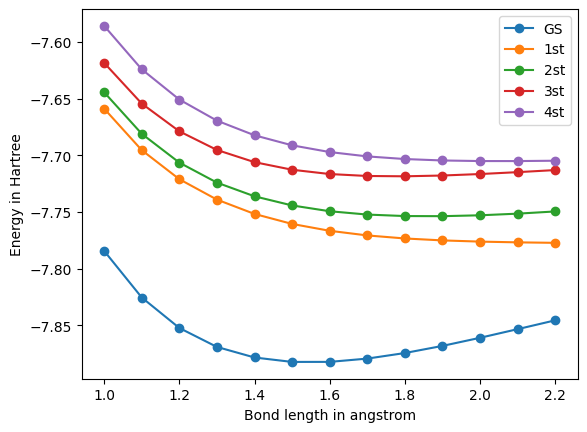

In [11]:
# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies[:,0], 'o-', label='GS')
plt.plot(bond_lengths, fci_energies[:,1], 'o-', label='1st')
plt.plot(bond_lengths, fci_energies[:,2], 'o-', label='2st')
plt.plot(bond_lengths, fci_energies[:,3], 'o-', label='3st')
plt.plot(bond_lengths, fci_energies[:,4], 'o-', label='4st')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend()
plt.show()

## H2O/STO-3G

In [12]:
# Set molecule parameters.
# We do not run calculations through OpenFermion directly.
basis        = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
bond_length_interval = 0.1
n_points = 12
bond_lengths = []
fci_energies = []

for point in range(n_points):
    bond_length    = 0.5 + point * bond_length_interval
    geometry       = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    # Generate a MolecularData instance
    molecule       = MolecularData(geometry, basis, multiplicity)
    
    file_directory = '/Users/yongbinkim/Desktop/venv/qeom/OpenFermion-QChem/examples/H2O/eom-ccsd/sto-3g/'\
                      +str(round(bond_length,2))+'/'
    # Update the MolecularData instance
    molecule   = run_qchem(molecule,file_directory=file_directory,output_name='test_qis')
    fermi      = Fermi_ops(molecule.one_body_integrals)
    fermi     += Fermi_ops(molecule.two_body_integrals*0.25, body="TWO")
    sparse_ham = openfermion.linalg.get_number_preserving_sparse_operator(fermi,molecule.n_qubits,molecule.n_electrons)

    mat  = sparse_ham.toarray() # type: np.ndarray
    w,v  = np.linalg.eigh(mat)
    ene  = rm_duplicate(w+molecule.nuclear_repulsion)
    fci_energies.append(ene)
    bond_lengths.append(bond_length)
    
fci_energies = np.array(fci_energies)
bond_lengths = np.array(bond_lengths)

In [13]:
str_format(bond_lengths,fci_energies)

Total Energy
0.50 -73.1376439090 -72.1679719927 -72.0877042730 -72.0857178126 -72.0601227111 -71.7677587169 -71.7406294353 -71.7130590591 -71.7031798239
0.60 -74.1462041519 -73.2880126202 -73.2050367967 -73.1938992640 -73.1562659904 -73.0240836064 -72.9862882012 -72.9780707511 -72.9090554179
0.70 -74.6436929789 -73.9245208200 -73.8455895130 -73.8212466734 -73.7712676093 -73.7431708843 -73.7050591358 -73.6816164715 -73.5759386984
0.80 -74.8830017837 -74.3018311504 -74.2294681585 -74.1944811854 -74.1619905113 -74.1288793147 -74.1237881563 -74.0897265711 -73.9811035890
0.90 -74.9876927042 -74.5285276986 -74.4639929161 -74.4221639974 -74.4123804913 -74.3745863851 -74.3376553364 -74.3358049254 -74.2303495411
1.00 -75.0198548004 -74.6623182328 -74.6061632057 -74.5631262249 -74.5617271796 -74.5264421874 -74.4890050084 -74.4563653712 -74.3820728038
1.10 -75.0126246020 -74.7369364449 -74.6892753690 -74.6523498009 -74.6461641389 -74.6175448118 -74.5854407100 -74.5201973128 -74.4712360107
1.20 -7

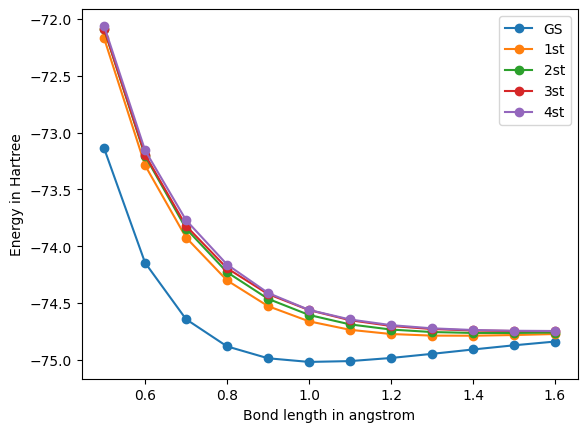

In [14]:
# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies[:,0], 'o-', label='GS')
plt.plot(bond_lengths, fci_energies[:,1], 'o-', label='1st')
plt.plot(bond_lengths, fci_energies[:,2], 'o-', label='2st')
plt.plot(bond_lengths, fci_energies[:,3], 'o-', label='3st')
plt.plot(bond_lengths, fci_energies[:,4], 'o-', label='4st')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend()
plt.show()